# Simple Function Approximation with PFNs
Approximating exp(-10x)*sin(2x) using a Predictive Forward Network

In [2]:
import torch
import math
import matplotlib.pyplot as plt

from pfns.train import train, MainConfig, BatchShapeSamplerConfig, OptimizerConfig, TransformerConfig
from pfns.priors.batched_discrete_bayes import DiscretePrior, DiscreteBayes, x_sampler
from pfns.priors.prior import AdhocPriorConfig
from pfns.model import bar_distribution
from pfns.model.criterions import BarDistributionConfig

## Define Simple Prior

In [147]:
f = lambda x: torch.exp(-1.5*x) * torch.cos(8*x)

class SimpleSineWave(DiscretePrior):
    def __init__(self, weights, noise_std=0.01):
        super().__init__(weights)
        self.noise_std = noise_std
        self.noise_dist = torch.distributions.Normal(
            torch.tensor(0.0), 
            torch.tensor(noise_std)
        )
    
    def mean_y(self, x, latent_indices=None):
        # Target function: exp(-0.1x)*sin(2πx)
        return f(x)
    
    def sample_xy(self, num_samples=1):
        x = x_sampler(num_samples)
        y = self.mean_y(x)[:, 0]
        y += self.noise_dist.sample(y.shape)
        return x, y
    
    def xy_logprob(self, x, y):
        if len(y.shape) == 1:
            y = y[:, None]
        mean_y = self.mean_y(x)
        y_logprob = self.noise_dist.log_prob(y - mean_y)
        x_logprob = x_sampler.logprob(x)
        return y_logprob + x_logprob

## Visualize Target Function

/tmp/ipykernel_26015/3017305521.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


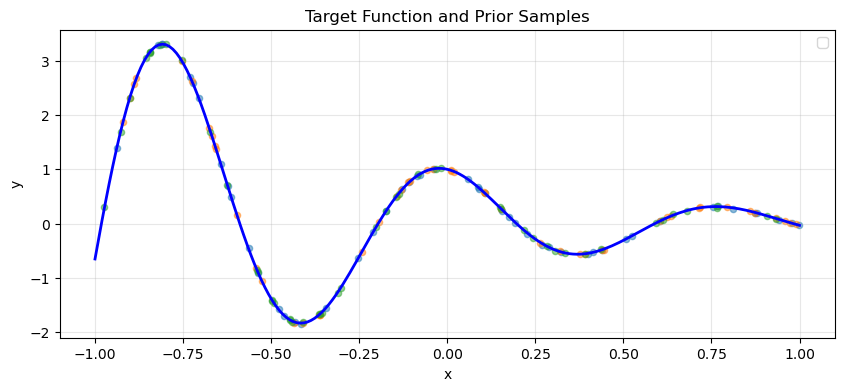

In [148]:
# Create prior and visualize
weights = torch.ones(1)
simple_prior = SimpleSineWave(weights)

# Sample and plot
x_plot = torch.linspace(-1, 1, 200)[:, None]
y_target = simple_prior.mean_y(x_plot)

plt.figure(figsize=(10, 4))
plt.plot(x_plot.numpy(), y_target.numpy(), 'b-', linewidth=2)

# Sample from prior
for _ in range(3):
    x, y = simple_prior.sample_xy(num_samples=50)
    plt.scatter(x.numpy(), y.numpy(), alpha=0.5, s=20)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Target Function and Prior Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Setup Training Configuration

Sampling y values for bar distribution...
Created bar distribution with 32 bars
Y range: [-1.8631, 3.3385]
Border range: [-2.7947, 5.0077]


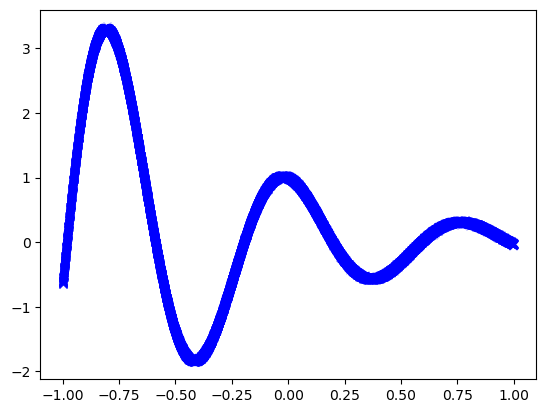

In [130]:
# Create the prior
bayes_prior = DiscreteBayes([simple_prior])

# Create wrapper to fix dimension ordering (batch-first format)
from pfns.priors import Batch
bs = 32
def get_batch_wrapper(batch_size, seq_len, num_features, **kwargs):
    batch = bayes_prior.get_batch(batch_size, seq_len, num_features, **kwargs)
    # Transpose from (seq_len, batch_size, features) to (batch_size, seq_len, features)
    return Batch(
        x=batch.x.transpose(0, 1),
        y=batch.y.transpose(0, 1),
        target_y=batch.target_y.transpose(0, 1),
    )

get_batch = get_batch_wrapper

# Sample y values to create bar distribution with WIDER range
print("Sampling y values for bar distribution...")
ys = []
xs = []
for _ in range(50):  # More samples for better coverage
    batch = get_batch(batch_size=bs, seq_len=20, num_features=1)
    ys.append(batch.target_y)
    xs.append(batch.x)
ys = torch.cat(ys).flatten()
xs = torch.cat(xs).flatten()
# Create bar distribution with widened borders to handle edge cases
borders = bar_distribution.get_bucket_borders(
    32, 
    ys=ys,
    widen_borders_factor=1.5  # Widen by 50% to handle values outside training range
)
print(f"Created bar distribution with {len(borders)-1} bars")
print(f"Y range: [{ys.min():.4f}, {ys.max():.4f}]")
print(f"Border range: [{borders.min():.4f}, {borders.max():.4f}]")

plt.plot(xs.numpy(), ys.numpy(), 'bx', alpha=0.3, label='Sampled y values')

## Train PFN Model 3 epochs

In [170]:
# Create the MainConfig
config = MainConfig(
    priors=[AdhocPriorConfig(get_batch_methods=get_batch)],
    optimizer=OptimizerConfig(optimizer="adamw", lr=1e-3, weight_decay=1e-4),
    model=TransformerConfig(
        criterion=BarDistributionConfig(
            borders=borders.tolist(),
            full_support=True
        ),
        emsize=64,
        nhid=256,
        nlayers=3,
        nhead=2,
    ),
    batch_shape_sampler=BatchShapeSamplerConfig(
        batch_size=bs,
        max_seq_len=20,
        min_num_features=1,
        max_num_features=1,
    ),
    epochs=3,
    steps_per_epoch=8,
    warmup_epochs=1,
    verbose=True,
)

print("Starting training...")
result = train(config, reusable_config=False)
print("\nTraining complete!")
print(f"Final loss: {result['total_loss']:.4f}")
print(f"Training time: {result['total_time']:.2f}s")

model = result['model']

Starting training...
init dist
Not using distributed
ALL: Using device cpu.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_batch_wrapper (batch_size, seq_len, num_features, **kwargs)
)), 'num_steps': 8, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=32, min_single_eval_pos=0, max_seq_len=20, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 4, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cpu', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_batch_wrapper (batch_size, seq_len, num_features, **kwargs)
)), 'num_steps': 8, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=32, min_single_eval_pos=0, max_se

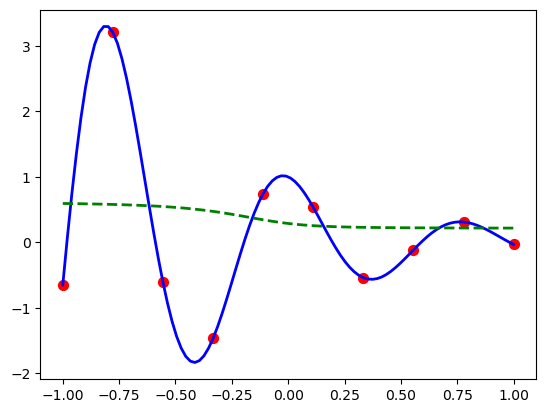

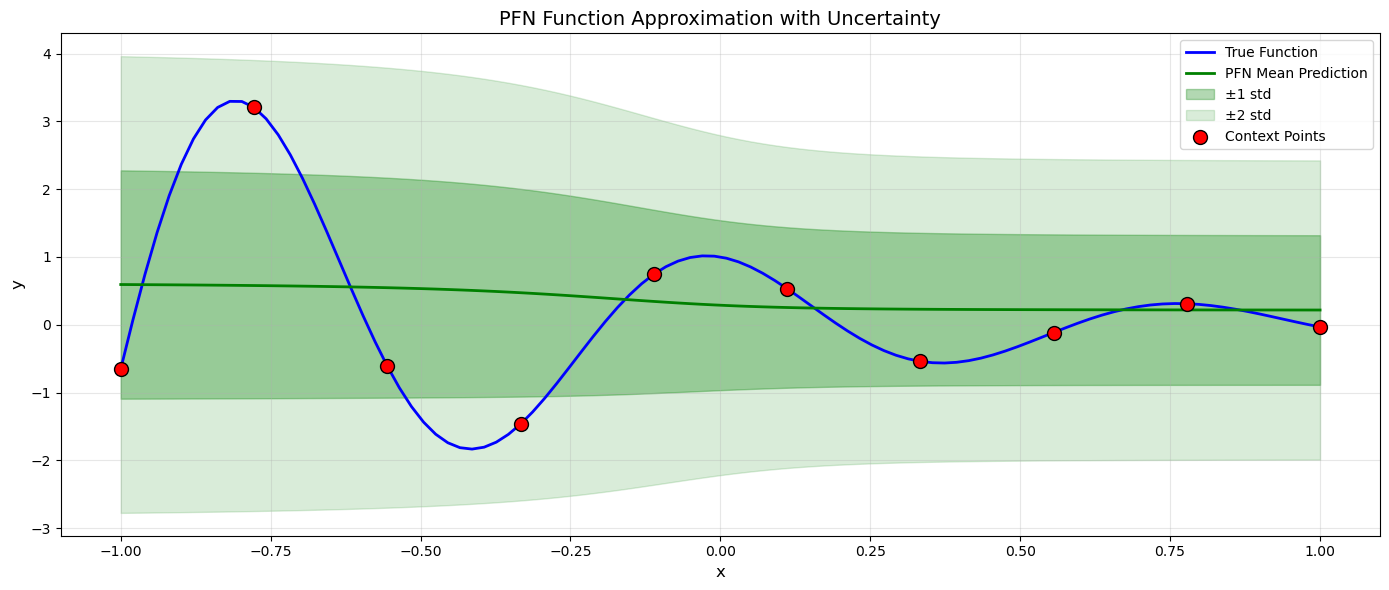

In [171]:
def plot_mean(model, n_context=10, n_query=100):
    model.eval()

    # Context
    x_context = torch.linspace(-1, 1, n_context)[:, None]
    y_context = f(x_context)


    # Queries
    x_query = torch.linspace(-1, 1, n_query)[:, None]
    # x_query = torch.tensor([[0.5]])

    x_true = torch.linspace(-1, 1, 100)[:, None]
    y_true = f(x_true)

    with torch.no_grad():
        logits = model(
            x=x_context.unsqueeze(0),
            y=y_context.unsqueeze(0),
            test_x=x_query.unsqueeze(0),
            only_return_standard_out=True,
        )
        probs = torch.softmax(logits, dim=-1)
        y_pred = model.criterion.mean(logits).squeeze(0)
    plt.plot(x_true.numpy(), y_true.numpy(), 'b-', linewidth=2)
    plt.scatter(x_context.numpy(), y_context.numpy(), c='r', s=50, label='Context Points')
    plt.plot(x_query.numpy(), y_pred.numpy(), 'g--', linewidth=2, label='PFN Prediction')

def plot_mean_and_std(model, n_context=10, n_query=100):
    model.eval()

    # Context
    x_context = torch.linspace(-1, 1, n_context)[:, None]
    y_context = f(x_context)

    x_query = torch.linspace(-1, 1, n_query)[:, None]
    y_true = f(x_query)

    with torch.no_grad():
        logits = model(
            x=x_context.unsqueeze(0),
            y=y_context.unsqueeze(0),
            test_x=x_query.unsqueeze(0),
            only_return_standard_out=True,
        )

        y_pred = model.criterion.mean(logits).squeeze(0)

        mean_of_square = model.criterion.mean_of_square(logits).squeeze(0)
        std = torch.sqrt(mean_of_square - y_pred**2)


    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot true function
    ax.plot(x_query.numpy(), y_true.numpy(), 'b-', linewidth=2, label='True Function', zorder=3)

    # Plot predicted mean
    ax.plot(x_query.numpy(), y_pred.numpy(), 'g-', linewidth=2, label='PFN Mean Prediction', zorder=4)

    ax.fill_between(x_query.squeeze().numpy(), 
                    (y_pred - std).numpy(), 
                    (y_pred + std).numpy(), 
                    alpha=0.3, color='green', label='±1 std', zorder=1)

    ax.fill_between(x_query.squeeze().numpy(), 
                    (y_pred - 2*std).numpy(), 
                    (y_pred + 2*std).numpy(), 
                    alpha=0.15, color='green', label='±2 std', zorder=0)


    ax.scatter(x_context.numpy(), y_context.numpy(), c='r', s=100, 
            label='Context Points', zorder=5, edgecolors='black', linewidths=1)

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('PFN Function Approximation with Uncertainty', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_mean(model)
plot_mean_and_std(model)

## Train PFN Model 10 epochs

In [ ]:
# Create the MainConfig
config = MainConfig(
    priors=[AdhocPriorConfig(get_batch_methods=get_batch)],
    optimizer=OptimizerConfig(optimizer="adamw", lr=1e-3, weight_decay=1e-4),
    model=TransformerConfig(
        criterion=BarDistributionConfig(
            borders=borders.tolist(),
            full_support=True
        ),
        emsize=64,
        nhid=256,
        nlayers=3,
        nhead=2,
    ),
    batch_shape_sampler=BatchShapeSamplerConfig(
        batch_size=bs,
        max_seq_len=20,
        min_num_features=1,
        max_num_features=1,
    ),
    epochs=20,
    steps_per_epoch=8,
    warmup_epochs=1,
    verbose=True,
)

print("Starting training...")
result = train(config, reusable_config=False)
print("\nTraining complete!")
print(f"Final loss: {result['total_loss']:.4f}")
print(f"Training time: {result['total_time']:.2f}s")

model = result['model']

In [ ]:
plot_mean(model)
plot_mean_and_std(model)